In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from Timer import Timer
import IPythonMagic

import pycuda.compiler as cuda_compiler
import pycuda.driver as cuda_driver

from pycuda.gpuarray import GPUArray

import pytest
from ipytest import clean_tests,run_pytest

In [2]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 9912 / 11441 MB available
Created context handle <42248944>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Orlando_Giuseppe/MilanoGPU2018/notebooks/cuda_cache


In [15]:
class HeatEquation1DGPU(object):
    """
    This class aprroximates the solution of heat equation using an explicit finite difference scheme on the GPU
    """
    
    # Empty constructor
    def __init__(self):
        pass
    
    def createKernel(self):
        src = """
        __global__ void heatEquation(float*u1,const float*u0,float kappa,float dx,float dt,int nx) {
            // Skip the first node
            int i = blockIdx.x*blockDim.x + threadIdx.x + 1;
            
            if(i >=1 && i <= nx) {
                u1[i] = u0[i] + kappa*dt/(dx*dx)*(u0[i-1] -2.0f*u0[i] + u0[i+1]);
            }
            
            if(i==1) {
                u1[0] = u0[i] + kappa*dt/(dx*dx)*(u0[i-1] -2.0f*u0[i] + u0[i+1]);
            }
            
            if(i==nx) {
                u1[nx+1] = u0[i] + kappa*dt/(dx*dx)*(u0[i-1] -2.0f*u0[i] + u0[i+1]);
            }
        }
        
        // This is a device function which we can call form the Kernel
        __device__ int computePi() {
            return 355.0f/113.0f;
        }
        """
        
        self.module = cuda_compiler.SourceModule(src,options=['--use_fast_math'])
        self.kernel = self.module.get_function("heatEquation")
        self.kernel.prepare("PPfffi")
    
    def initialize(self,u0,kappa,dx,dt):
        self.kappa = np.float32(kappa)
        self.dx = np.float32(dx)
        self.dt = np.float32(dt)
        # nx is the number of internal nodes
        self.nx = np.int32(u0.shape[0] - 2)
         
        # Allocate data on GPU and Upload
        assert u0.dtype == np.float32, "u0 must be float"
        self.u0_g = GPUArray(u0.shape,u0.dtype)
        self.u1_g = GPUArray(u0.shape,u0.dtype)
        self.u0_g.set(u0)
        
        #Create the kernel
        self.createKernel()
        
        num_threads = 128
        self.block_size = (num_threads,1,1)
        self.grid_size = (int(np.ceil(self.u0_g.shape[0]/num_threads)),1,1)
        self.stream = cuda_driver.Stream()
        print("Grid size is: ",self.grid_size)
        print("Block size is: ",self.block_size)
        print("U0 shape is: ",self.u0_g.shape)
    
    def step(self):
        
        #for i in range(1,self.nx+1):
        #    self.u1[i] = self.u0[i] + self.kappa*self.dt/self.dx**2*(self.u0[i-1] - 2.0*self.u0[i] + self.u0[i+1])
        ##Neumann bc (we transport the same value of first cell so we impose null flux)
        self.kernel.prepared_async_call(self.grid_size,self.block_size,self.stream,\
                                        self.u1_g.gpudata,self.u0_g.gpudata,self.kappa,self.dx,self.dt,self.nx)
        #We wiil fix bc in the kerneò
        #self.u1[0] = self.u1[1]
        #self.u1[self.nx+1] = self.u1[self.nx]       
              
        #Swap u1,u0
        #After that u0 is the most recent (it moves pointer)
        self.u0_g,self.u1_g = self.u1_g,self.u0_g
    
    def download(self):
        u0 = np.empty(self.u0_g.shape,self.u0_g.dtype)
        self.u0_g.get(u0)
        return u0

In [16]:
u0 = np.zeros(5,dtype = np.float32)
u0[2] = 1.0
kappa = 1.0
dx = 1.0
dt = 0.4*dx**2/(2.0*kappa)

gpu_simulator = HeatEquation1DGPU()
gpu_simulator.initialize(u0,kappa,dx,dt)
gpu_simulator.step()
result = gpu_simulator.download()
print(result)


#for i in range(10):
#    gpusimulator.step()

#    result = simulator.download()
#print(result) 
#fig = plt.figure()
#plt.plot(result)

Grid size is:  (1, 1, 1)
Block size is:  (128, 1, 1)
U0 shape is:  (5,)
[0.2 0.2 0.6 0.2 0.2]


In [24]:
print(gpu_simulator.kernel)

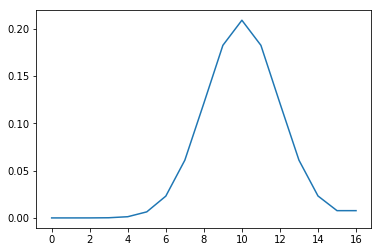

In [14]:
u0 = np.zeros(17)
u0[10] = 1.0
kappa = 1.0
dx = 1.0
dt = 0.4*dx**2/(2.0*kappa)

simulator = HeatEquation1D(u0,kappa,dx,dt)
for i in range(10):
    simulator.step()

    result = simulator.download()
#print(result) 
fig = plt.figure()
plt.plot(result)

In [7]:
clean_tests()

def test_HeatEquation1D():
    u0 = np.zeros(15)
    kappa = 1.0
    dx = 1.0
    dt = 0.4*dx**2/(2.0*kappa)

    simulator = HeatEquation1D(u0,kappa,dx,dt)
    
    assert np.all(u0 == simulator.u0)
    assert kappa == simulator.kappa
    assert dx == simulator.dx
    assert dt == simulator.dt
    assert simulator.u0.shape == simulator.u1.shape
    
    u0 = np.zeros(7)
    u0[3] = 1.0
    kappa = 1.0
    dx = 1.0
    dt = 0.4*dx**2/(2.0*kappa)

    simulator = HeatEquation1D(u0,kappa,dx,dt)
    for i in range(10):    
        simulator.step()
        result = simulator.download()
        print(result)
        # assert np.sum(result) == pytest.approx(1.0) With bc obviously it fails  
        assert np.sum(result[1:-1]) == pytest.approx(1.0)  
        assert result[0] == result[1]
        assert result[-1] == result[-2]               
    
run_pytest(filename='HeatEquation1D.ipynb',pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Orlando_Giuseppe/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

HeatEquation1D.py::test_HeatEquation1D <- <ipython-input-7-191723c4ed6f> PASSED [100%]

=========================== 1 passed in 0.03 seconds ===========================


0